In [1]:
import numpy as np
import pandas as pd
import os, sys

sys.path.append(os.path.abspath("C:\\Users\\chris_000\\PycharmProjects\\cisco_project\\src"))
import loader, em

from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [2]:
RL_final = loader.produce_labelsarray("exec")

Loading in RL info table (master file list)
Master file corpus size:  3829275
File corpus size fulfilling docstring exec: 2426854
Filter size:  2242949
ID Array size:  2242949
Reading in features IDs
ThreatGrid file corpus size:  3814330
Loading in AV hits data
Pivoting hits data
Merging data into ID array
Subbing in zero values for *clean* files
Complete.


In [3]:
TG_ioc = loader.get_TGfeatures(RL_final['submission_id'].values)

Loading ThreatGrid features data file
Feature array size:  19600053
Filtering to include only files in corpus
Feature array size:  16277953


In [4]:
#RL_final = RL_final[RL_final['submission_id'] != 0]
#RL_final.reset_index(drop=True, inplace=True)
RL_final.head()

index                                             sha256  scan_length  \
0      0  c2618aed5a8e4d11e9bcc7ee8505c8e3bd2e2d0f741a60...    37.191667   
1      1  c26b9b1dfa66611a2d116900f225ee789d16c2314016fe...    38.401389   
2      2  c26318ed21f7d5fd22e48f3136f8c621bcd9fb0e66845e...     7.009028   
3      3  c261955f613c161c1dd70ef1e225f27edcf3a47ec03c0e...   292.647917   
4      5  c2699f0383452ec83ba6cde810f0e5a9e287484896bc9c...    40.070833   

   submission_id  ahnlab  antivir  avast  avg  bitdefender  ca_av     ...      \
0              0       0        0      0    0            0      0     ...       
1      128232933       1        1      0    1            0      0     ...       
2              0       0        0      0    0            0      0     ...       
3      128493663       1        1      1    1            1      0     ...       
4      128514428       1        1      1    1            1      0     ...       

   sunbelt  symantec  symantec_beta  symantec_online  trendmicro  \
0        0         0              0                0           0   
1        1         0              1                0           0   
2        0         0              0                0           0   
3        1         0              1                0           0   
4        1         0              1                0           0   

   trendmicro_beta  trendmicro_consumer  vba32  virusbuster  true_label  
0                0                    0      0            0         NaN  
1                0                    1      1            0         NaN  
2                0                    0      0            0         NaN  
3                0                    1      1            0         NaN  
4                0                    1      1            1         NaN  

[5 rows x 45 columns]

In [5]:
RL_temp = pd.DataFrame(RL_final['submission_id'])
RL_temp['RL_index'] = RL_temp.index

In [6]:
TG_ioc = pd.merge(left=TG_ioc, right=RL_temp, how='left', left_on='submission_id', right_on='submission_id')

In [7]:
# Construct sparse matrix
feats = csr_matrix((np.ones(len(TG_ioc)), 
                    (TG_ioc['RL_index'].values, TG_ioc['index'].values)), shape=(len(RL_final), 414))

In [47]:
X = RL_final.iloc[: ,4:].values

train_shape = X.shape
init_threshold = 4

N = X[0]
M = train_shape[1]
Z = np.array(X.sum(axis=1) >= init_threshold, dtype=int)

In [50]:
import importlib
importlib.reload(em)

<module 'em' from 'C:\\Users\\chris_000\\PycharmProjects\\cisco_project\\src\\em.py'>

In [51]:
#Z, alpha, beta, pi = em.EMAlgorithm_LogisticRegression(X, Z, feats, 1.1*N, 0.4*N)
params = em.EMAlgorithm_LogisticRegression(X, Z, feats, 1, 1)

Beginning EM algorithm with logistic regression...
Iteration 1 of 20
    Performing logistic regression on probabilistic labels...
    Total movement in alpha + beta:  23.3979694269
    Movement in logistic regression parameters:  6.81219913878
    Movement in ground truth probabilities:  1682061.71174
    Movement in ground truth labels:  73373
Iteration 2 of 20
    Performing logistic regression on probabilistic labels...
    Total movement in alpha + beta:  1.4839396472
    Movement in logistic regression parameters:  2.94121189808
    Movement in ground truth probabilities:  74160.2098281
    Movement in ground truth labels:  24770
Iteration 3 of 20
    Performing logistic regression on probabilistic labels...
    Total movement in alpha + beta:  0.602905104157
    Movement in logistic regression parameters:  2.54105942991
    Movement in ground truth probabilities:  25629.637728
    Movement in ground truth labels:  11823
Iteration 4 of 20
    Performing logistic regression on pro

In [66]:
Z = params[0]
alpha = params[1]
beta = params[2]
clf = params[3]

(array([  5.52229000e+05,   1.90800000e+03,   1.18100000e+03,
          9.70000000e+02,   9.15000000e+02,   9.45000000e+02,
          1.36300000e+03,   1.38900000e+03,   2.04400000e+03,
          1.55673800e+06]),
 array([  3.83611966e-32,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

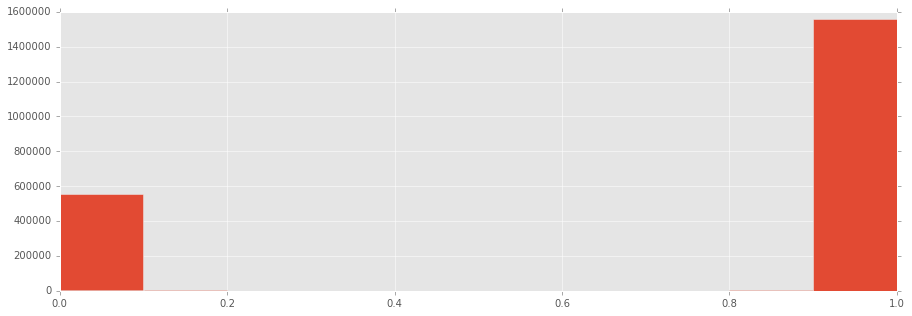

In [67]:
plt.hist(Z)

In [68]:
plt.xticks(np.arange(40),RL_final.columns[4:], rotation='vertical')
plt.plot(alpha,'ro')
plt.plot(beta,'bo')

In [69]:
verdicts = X.sum(axis=1)
propn = np.zeros(41)
for i in range(0, 41):
    amt = Z[verdicts==i]
    if len(amt) > 0:
        propn[i] = sum(amt>0.9) / len(amt)
    else: propn[i] = 0

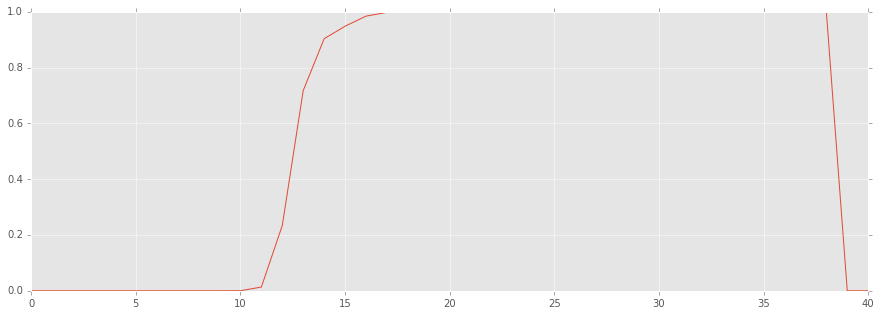

In [70]:
plt.plot(propn)

(array([   64968.,   248092.,   153029.,    96452.,    54586.,    46944.,
           62218.,    37599.,    75198.,  1280596.]),
 array([  6.36889997e-06,   1.00005732e-01,   2.00005095e-01,
          3.00004458e-01,   4.00003821e-01,   5.00003184e-01,
          6.00002548e-01,   7.00001911e-01,   8.00001274e-01,
          9.00000637e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

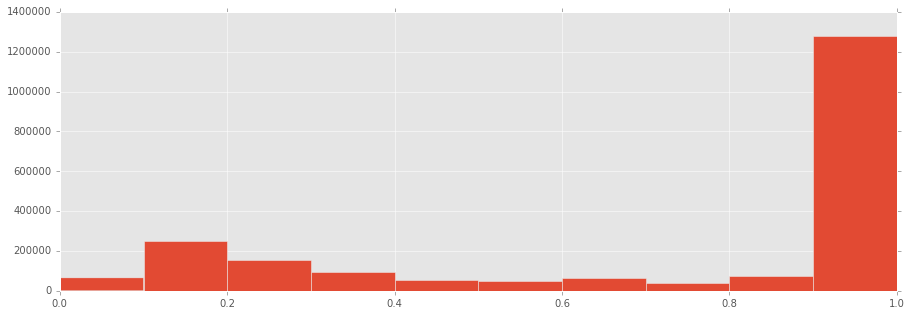

In [65]:
plt.hist(params[3].predict_proba(feats)[:,1])

In [79]:
rng = range(50)
train = np.random.choice(range(50), size=40, replace=False)
test = [r for r in rng if r not in train]
print(sorted(train))
print(test)

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 24, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 49]
[8, 14, 19, 22, 23, 25, 29, 34, 45, 48]


In [80]:
X.shape

(2119682, 40)

In [87]:
a = np.prod(alpha**X * (1 - alpha)**(1-X), axis=1)
b = np.prod((1-beta)**X * beta**(1-X), axis=1)

In [95]:
res = feats[:,413]
res

<2119682x1 sparse matrix of type '<class 'numpy.float64'>'
	with 103593 stored elements in Compressed Sparse Row format>

In [8]:
#RL_final['true_label'] = np.nan
true_labels = np.empty(len(RL_final))
X = RL_final.iloc[:,4:-1].values

In [19]:
arr1 = np.array(X.sum(axis=1) >= 20)
arr2 = np.array(X.sum(axis=1) == 0)
arr3 = np.array(RL_final['scan_length'].values >= 30)
arr4 = np.logical_and(arr2, arr3)

In [20]:
true_labels = np.nan * np.ones(len(RL_final))
true_labels[arr1] = 1
true_labels[arr4] = 0
RL_final['true_label'] = true_labels
RL_final

index                                             sha256  \
0              0  c2618aed5a8e4d11e9bcc7ee8505c8e3bd2e2d0f741a60...   
1              1  c26b9b1dfa66611a2d116900f225ee789d16c2314016fe...   
2              2  c26318ed21f7d5fd22e48f3136f8c621bcd9fb0e66845e...   
3              3  c261955f613c161c1dd70ef1e225f27edcf3a47ec03c0e...   
4              5  c2699f0383452ec83ba6cde810f0e5a9e287484896bc9c...   
5              7  c26ae28a2b23ba4b87c92e49c2e4d710a6d503f26c4774...   
6             12  c26d3a0d177abc98c7f7ccd22fcee937231b5dfe40be9f...   
7             13  c2639650aff5ee8ce376cf8130f0351c825718385158c7...   
8             16  c2672a763ee194d4ce4d5c09668a00fd0033a49f57c645...   
9             21  c263a603ed5dba072fdc0e6e37539c9a7d54e722cc108b...   
10            22  c268e2c51094123d7ac5cab8ba10f5a9e7504b283d5ded...   
11            27  c265a308c2e213f822728b39780dc405f7e4f952bfa428...   
12            29  c2641099fae2e725457c3331192a0a2c8db04ad75f19f0...   
13            31  c2678578a0dda8c89e000ecf3a7f64a7521d3b5a5f1001...   
14            34  c263f6f56e3236acf5afef4bdb08b749e28e6873dc1629...   
15            35  c26c2bbb854ba082aa122997c42702f9df934aff597fb3...   
16            38  c261a7bad97c91bf85b1a50a387e09fb357cd3036d9191...   
17            40  c26d4acd70a8947990022540fdbd9c4503ff0fdef64920...   
18            42  c26f0433957f4c82c5132716fb44854da24b9873ce88fd...   
19            46  c26cad7fc8f4774dc2716d88e73d4b9da3b3c1d674a99f...   
20            47  c265e1bd57998c8b114df851e323d0b39f85c9784c6a99...   
21            48  c26b95c279bba4dacc94eafc0b820e363272ffc180987d...   
22            49  c267c3ef0b0c80f9fd990cbb3329f3bf2545b50e27af01...   
23            52  c26e535bdce79e3846cb0de9ab0e8466d93b369c2ea050...   
24            57  c26722091954335c8c0f97f788fe67975406391db3c08a...   
25            62  c26b1a23e0bf2454e5e37d61b160d1e31f9888f17d44d6...   
26            64  c26a9d33743756f6eb228652e45723f009fdb5c032ebce...   
27            67  c266de983b6af64262abbcea132154c427bdc6c8ffea51...   
28            68  c26bf72cf865d5c75f9f9ca08296c1bef74bd1565298fa...   
29            73  c26324647e404d96285d848d17f7026204cc244792e8f4...   
...          ...                                                ...   
2242919  4108734  7e6c56403733cbd4924bf8e2531ab3ac824a3468acbb28...   
2242920  4108735  7e69150007c708db61f5ae0af5c8d9dd690359af0c249e...   
2242921  4108737  7e66bf9fbc8376d5f3aeec834c07e2b1020e68f7fe87c9...   
2242922  4108739  7e674587455d94c7323446bd75a598070337078134abd4...   
2242923  4108740  7e6d10fec5c8922d68b918673ca3e45b33f0581fa87c10...   
2242924  4108741  7e68597340e650a16f05909ff3d72ef96e57adad893704...   
2242925  4108742  7e661d665032b24b9db0e71d709a717d7aa9637f477b33...   
2242926  4108748  7e676e951829d50a08a0c1d5296472f852d97effd9d1a4...   
2242927  4108750  7e6fdff7ba9e0793603cb79605f9d207f85e071246b269...   
2242928  4108751  7e63ccbd88cd0f64e4d35e7059d8315073332430d6fb29...   
2242929  4108752  7e62148686f96178c383b0791073bd0a32fd53ac5c469e...   
2242930  4108754  7e6225571da5dc217217a7c6417cf6952ad6deacbfd202...   
2242931  4108755  7e62a037051cfd9bf4bfa007990adc386c7effd034971c...   
2242932  4108756  7e66820f763291fbd298efeac404350e341643fc97eec1...   
2242933  4108759  7e6728b1edabc15c37002bd2b625207a554c3258986cc6...   
2242934  4108760  7e6c025cadca09ccdfb91a09675bf04269e8082985b39c...   
2242935  4108761  7e62d45f5b796e89a84ecd99a22a95d130eb1d68ea0ec3...   
2242936  4108764  7e667bb45b097c4f6711f7d5f7a03357471b18369094c7...   
2242937  4108765  7e61c945275861688c57de3f9cf7ea5760c7f4d18001cd...   
2242938  4108767  7e69dada3a12eb7d01ff4eb2fa42a1395643013497cf69...   
2242939  4108768  7e6c179fdbe5391d2832a5af240e6ac752d2ea4a3f6222...   
2242940  4108769  7e6c1f950a908a8196e776c739cbd47d8d2834bda42d84...   
2242941  4108770  7e6f9c970fb113b6aa7d7f88e0d77158260e829e7118d7...   
2242942  4108772  7e649f0fd6fd13105d23b40fd33578eb38e1bf933a46b7...   
2242943  4108773  7e64f4d0fe594db36

In [21]:
RL_final['true_label'].value_counts()

1    1363193
0      75038
Name: true_label, dtype: int64